In [55]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import matplotlib.dates as dates

In [56]:
import uncertainties.unumpy as unp
import uncertainties as unc

In [57]:
import geopandas as gpd

### Functions

In [58]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [59]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [60]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [61]:
dfr = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [62]:
dfp['data'] = pd.to_datetime(dfp['data'])
dfr['data'] = pd.to_datetime(dfr['data'])
df['data'] = pd.to_datetime(df['data'])

In [63]:
fr = 'italia/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp'
mapr_df = gpd.read_file(fr)
mapr_df.loc[mapr_df.DEN_REG == 'Emilia-Romagna','DEN_REG'] = 'Emilia Romagna'

fp = 'italia/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp'
mapp_df = gpd.read_file(fp)

#adding BZ and TN provinces to regions
mapr_df = mapr_df.append(mapp_df.loc[mapp_df.DEN_PCM == 'Trento', ['COD_RIP', 'COD_REG', 'Shape_Leng', 'Shape_Area',
       'geometry']], ignore_index=True, sort=True)
mapr_df.loc[20,'DEN_REG'] = 'P.A. Trento'

mapr_df = mapr_df.append(mapp_df.loc[mapp_df.DEN_PCM == 'Bolzano', ['COD_RIP', 'COD_REG', 'Shape_Leng', 'Shape_Area',
       'geometry']], ignore_index=True, sort=True)
mapr_df.loc[21,'DEN_REG'] = 'P.A. Bolzano'

In [64]:
dfpop = pd.read_csv('dati_regioni.csv')

In [65]:
#dfp = dfp.set_index('denominazione_provincia').join(mapp_df.set_index('DEN_PCM').geometry)
#dfr = dfr.set_index('denominazione_regione').join(mapr_df.set_index('DEN_REG').geometry)

In [66]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
24,2020-03-19 17:00:00,ITA,15757,2498,18255,14935,33190,4480,4440,3405,41035,182777
25,2020-03-20 17:00:00,ITA,16020,2655,18675,19185,37860,4670,5129,4032,47021,206886
26,2020-03-21 17:00:00,ITA,17708,2857,20565,22116,42681,4821,6072,4825,53578,233222
27,2020-03-22 17:00:00,ITA,19846,3009,22855,23783,46638,3957,7024,5476,59138,258402
28,2020-03-23 17:00:00,ITA,20692,3204,23896,26522,50418,3780,7432,6077,63927,275468


# ITALIA

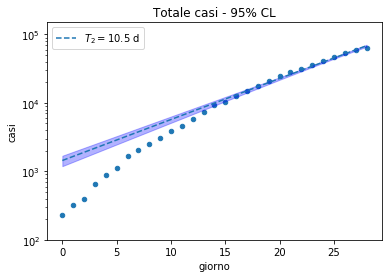

In [74]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim = [10**2,1.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])
popt1, pcov1 = optimize.curve_fit(powerlaw, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label)

#ax.plot(px[:last_day],powerlaw(px[:last_day], *popt1), ls = 'dashed', color = 'red')

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('casi')
ax.legend()
#print( max(df.data).date())
fig.savefig('plot/'+ str(max(df.data).date()) + '-Emanuele-Italia-totale-casi.png', dpi = 300)

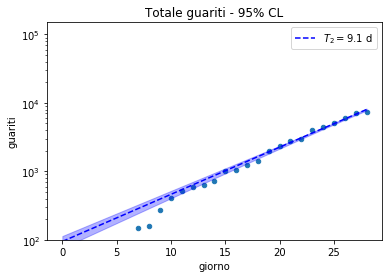

In [73]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='dimessi_guariti', ax = ax, logy = True, title = 'Totale guariti - 95% CL', ylim = [10**2,1.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.dimessi_guariti[dd:])
popt1, pcov1 = optimize.curve_fit(powerlaw, x[dd:], df.dimessi_guariti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label, color = 'blue')

#ax.plot(px[:last_day],powerlaw(px[:last_day], *popt1), ls = 'dashed', color = 'red')

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('guariti')
ax.legend()
#print( max(df.data).date())
fig.savefig('plot/'+ str(max(df.data).date()) + '-Emanuele-Italia-totale-guariti.png', dpi = 300)

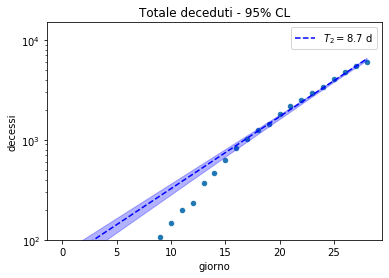

In [72]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='deceduti', ax = ax, logy = True, title = 'Totale deceduti - 95% CL', ylim = [10**2,1.5*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.deceduti[dd:])
popt1, pcov1 = optimize.curve_fit(powerlaw, x[dd:], df.deceduti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label, color = 'blue')

#ax.plot(px[:last_day],powerlaw(px[:last_day], *popt1), ls = 'dashed', color = 'red')

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('decessi')
ax.legend()
#print( max(df.data).date())
fig.savefig('plot/'+ str(max(df.data).date()) + '-Emanuele-Italia-totale-deceduti.png', dpi = 300)

# Province

## Singola Provincia

ValueError: operands could not be broadcast together with shapes (18,) (28,) 

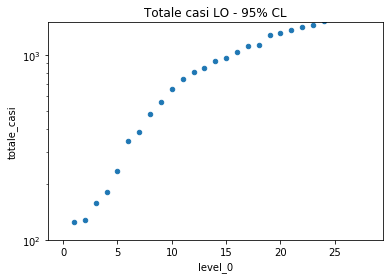

In [75]:
provincia = 'LO'

fig, ax = plt.subplots()

x = np.arange(19)
px = np.arange(20)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/'+ str(max(df.data).date()) +'-Emanuele-totale-casi-{}.png'.format(provincia), dpi = 300)

In [ ]:
dfp[dfp.sigla_provincia == provincia].to_csv('pr.csv')

## Analisi Province

In [76]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)
regioni = np.unique(dfp[dfp.denominazione_regione != ''].denominazione_regione.values)

In [77]:
time = max(dfp.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')].copy()
df_forecast.loc[:,'data'] = time
sLength = len(df_forecast['data'])
df_forecast = df_forecast.assign(std = np.zeros(sLength))
#df_forecast.head()

In [78]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr].copy()
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].data.values - min(df_temp[df_temp.totale_casi > 0].data.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

In [79]:
df_forecast.to_csv('forecast_province_2020.03.24.csv')
df_forecast.totale_casi.sum()

78164.5415458911

In [80]:
merged = mapp_df.set_index('DEN_PCM').join(df_forecast.set_index('denominazione_provincia'))
merged['log_totale_casi'] = merged['totale_casi'].apply(lambda x: max(0,np.log10(x)))

In [81]:
merged.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,SIGLA,Shape_Leng,Shape_Area,...,stato,codice_regione,denominazione_regione,codice_provincia,sigla_provincia,lat,long,totale_casi,std,log_totale_casi
DEN_PCM,,,,,,,,,,,,,,,,,,,,,
Torino,1,1,1,201,201,-,Torino,TO,539249.812320,6.828137e+09,...,ITA,1.0,Piemonte,1.0,TO,45.073274,7.680687,2916.801550,94.005018,3.464907
Vercelli,1,1,2,0,2,Vercelli,-,VC,418249.269903,2.082028e+09,...,ITA,1.0,Piemonte,2.0,VC,45.323981,8.423234,344.895283,15.935364,2.537687
Novara,1,1,3,0,3,Novara,-,NO,250242.386669,1.341320e+09,...,ITA,1.0,Piemonte,3.0,NO,45.445885,8.621916,571.109487,22.487465,2.756719
Cuneo,1,1,4,0,4,Cuneo,-,CN,490111.881760,6.898443e+09,...,ITA,1.0,Piemonte,4.0,CN,44.393296,7.551172,471.871334,14.775063,2.673824
Asti,1,1,5,0,5,Asti,-,AT,315561.373435,1.508948e+09,...,ITA,1.0,Piemonte,5.0,AT,44.899129,8.204143,208.063945,8.725419,2.318197


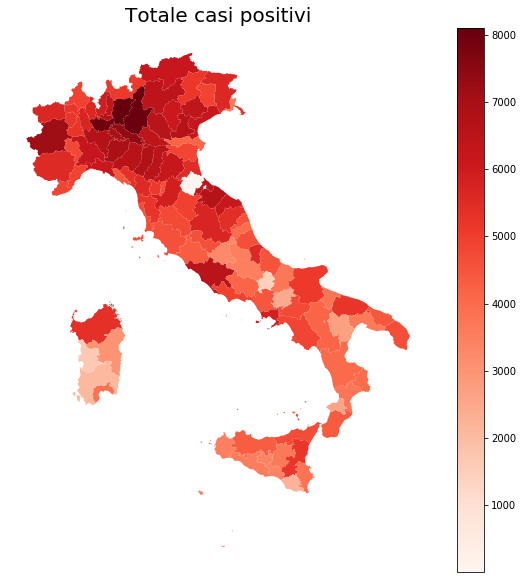

In [39]:
variable = 'log_totale_casi'
vmin, vmax  = min(merged[variable].values), max(merged[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

merged.plot(column = variable, cmap = 'Reds', ax = ax);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
scale = plt.cm.ScalarMappable(cmap ='Reds', norm = plt.Normalize(vmin=10**vmin, vmax=10**vmax))
cbar = fig.colorbar(scale)
plt.savefig('map.png', dpi = 300, bbox_inches = 'tight')

In [82]:
for reg in regioni:
    province = df_forecast[df_forecast.denominazione_regione == reg].denominazione_provincia.values
    if len(province)>4:
        col = 3
    elif len(province)>2:
        col = 2
    else: 
        col = 1
    row = int(len(province)/col) + (len(province)%col > 0) 
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12, 12), constrained_layout=True)
    day0, day1 = min(dfp.data.values) - np.timedelta64(1,'D'), max(dfp.data.values) + np.timedelta64(2,'D')

    if len(province)>1:
        for pr, ax in zip(province, axes.flat):
            x = df_forecast[(df_forecast.denominazione_provincia == pr)].data.values
            y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
            yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
            ax.scatter(x,y, color = 'red', s = 30)
            ax.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

            dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = ax, title = pr, xlim =[day0,day1])
            locator = dates.AutoDateLocator(minticks=5, maxticks=7)
            formatter = dates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('')
            ax.set_ylabel('')
    else:
        x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
        y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
        yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
        axes.scatter(x,y, color = 'red', s = 30)
        axes.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

        dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = axes, title = pr, xlim =[day0,day1])
        locator = dates.AutoDateLocator(minticks=5, maxticks=7)
        formatter = dates.ConciseDateFormatter(locator)
        axes.xaxis.set_major_locator(locator)
        axes.xaxis.set_major_formatter(formatter)
        axes.set_xlabel('')
        axes.set_ylabel('')
        
    fig.suptitle('Regione ' + reg, size = 14)
    for i in range(len(province),row*col):
        fig.delaxes(axes.flat[i])
    fig.savefig('plot/'+ str(max(dfp.data).date()) +'-Emanuele-Regione-'+reg+'.png', dpi = 200)
    plt.close()

# Regioni

In [83]:
time = max(dfr.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

dfr_forecast = dfr[(dfr.data == max(dfr.data.values)) & (dfr.denominazione_regione != '')].copy()
dfr_forecast.loc[:,'data'] = time
sLength = len(dfr_forecast)
dfr_forecast = dfr_forecast.assign(std = np.zeros(sLength))
dfr_forecast.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,std
588,2020-03-24 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,228,52,280,325,605,66,20,38,663,3674,0.0
589,2020-03-24 17:00:00,ITA,17,Basilicata,40.639471,15.805148,15,12,27,62,89,8,0,1,90,696,0.0
590,2020-03-24 17:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,145,33,178,510,688,40,7,29,724,6084,0.0
591,2020-03-24 17:00:00,ITA,18,Calabria,38.905976,16.594402,82,20,102,178,280,20,5,7,292,4073,0.0
592,2020-03-24 17:00:00,ITA,15,Campania,40.839566,14.250850,266,110,376,553,929,63,48,49,1026,5813,0.0


In [42]:
columns = dfr_forecast.columns[6:16]
for col in columns:
    d = {}
    for reg in regioni:
        df_temp = dfr[dfr.denominazione_regione == reg].copy()
        #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
        df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        try:
            x = df_temp[df_temp[col] > 0].data.values - min(df_temp[df_temp[col] > 0].data.values)
            y = df_temp[df_temp[col] > 0].totale_casi.values
            popt, pcov = optimize.curve_fit(exponential, x, y)

            y0,tau = unc.correlated_values(popt, pcov)
            py = y0*unp.exp((max(x)+1)/tau)

            nom = py.nominal_value
            std_new = py.std_dev
        except:
            nom = 0
            std_new = 0
        d[reg] = [nom,std_new]
    dfr_forecast[col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][0])
    dfr_forecast['std_'+col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][1])

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:178: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:227: RuntimeWarning: invalid value encountered in less
  variances[variances < 0] = 0.


In [43]:
dfr_forecast.to_csv('forecast_regioni_{}.csv'.format(max(dfr_forecast.data).date()))
dfr_forecast.totale_casi.sum()

79188.388882133

In [39]:
df = pd.read_csv('../model-DummyExp/dati_regioni.csv')
#df.loc[df.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

#dfr_forecast.loc[dfr_forecast.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

In [44]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr_forecast.set_index('denominazione_regione'))
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr = mergedr.rename(index = {'Trento': 'P.A. Trento', 'Bolzano': 'P.A. Bolzano'})
mergedr = mergedr.join(dfpop.set_index('denominazione_regione')['popolazione'])

#mergedr.loc['P. A. Trento',:] = mergedr['Trento']
#mergedr.loc['P. A. Bolzano',:] = mergedr['Bolzano']

## Totale casi previsti

[0. 1. 2. 3. 4.]


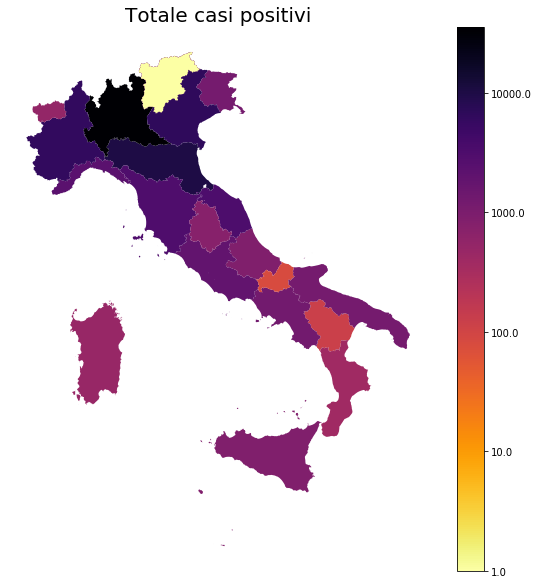

In [45]:
mergedr['log_totale_casi'] = mergedr['totale_casi'].apply(lambda x: max(0,np.log10(x)))
variable = 'log_totale_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])
print(yticks)

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels([round(10**ytick) for ytick in yticks])
plt.savefig('map_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')

In [47]:
mergedr['log_perc_casi'] = mergedr[['totale_casi', 'popolazione']].apply(lambda x: np.log10(x[0]/x[1]), axis = 1)

In [48]:
mergedr['log_perc_casi'] 

Abruzzo                 -3.177370
Basilicata              -3.663580
Calabria                -3.699062
Campania                -3.655076
Emilia Romagna          -2.648857
Friuli Venezia Giulia   -3.014187
Lazio                   -3.482052
Liguria                 -2.814753
Lombardia               -2.452431
Marche                  -2.673975
Molise                  -3.570066
P.A. Bolzano            -2.738418
P.A. Bolzano            -2.738418
P.A. Trento             -2.615958
P.A. Trento             -2.615958
Piemonte                -2.842343
Puglia                  -3.545045
Sardegna                -3.515127
Sicilia                 -3.760029
Toscana                 -3.072430
Trentino-Alto Adige           NaN
Umbria                  -3.067788
Valle d'Aosta           -2.370035
Veneto                  -2.864444
Name: log_perc_casi, dtype: float64

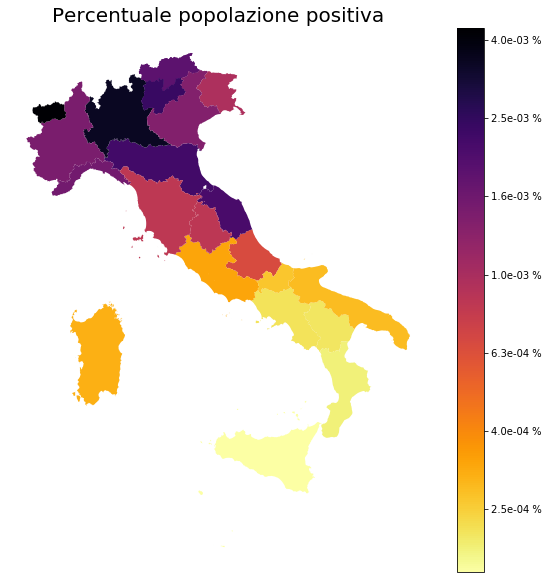

In [49]:
variable = 'log_perc_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'inferno_r', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Percentuale popolazione positiva', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels(['{:3.1e} %'.format(10**ytick) for ytick in yticks])
#['{:5.2e}'.format(x) for x in leak] 
plt.savefig('map_perc_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')

# Time evolution

In [52]:
day0, day1 = min(dfr.data), max(dfr.data)


DEN_REG
Piemonte                 6.886410e-07
Valle d'Aosta            0.000000e+00
Lombardia                1.709644e-05
Trentino-Alto Adige               NaN
Veneto                   6.726658e-06
Friuli Venezia Giulia    0.000000e+00
Liguria                  0.000000e+00
Emilia Romagna           4.036348e-06
Toscana                  0.000000e+00
Umbria                   0.000000e+00
Marche                   0.000000e+00
Lazio                    5.102837e-07
Abruzzo                  0.000000e+00
Molise                   0.000000e+00
Campania                 0.000000e+00
Puglia                   0.000000e+00
Basilicata               0.000000e+00
Calabria                 0.000000e+00
Sicilia                  0.000000e+00
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             0.000000e+00
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 6.886410e-07
Valle d'Aosta            0.000000e+00
Lombardia                2.385550e-05
Trentino-Alto Adige               NaN
Veneto                   8.765039e-06
Friuli Venezia Giulia    0.000000e+00
Liguria                  6.448950e-07
Emilia Romagna           5.830280e-06
Toscana                  5.362446e-07
Umbria                   0.000000e+00
Marche                   0.000000e+00
Lazio                    5.102837e-07
Abruzzo                  0.000000e+00
Molise                   0.000000e+00
Campania                 0.000000e+00
Puglia                   0.000000e+00
Basilicata               0.000000e+00
Calabria                 0.000000e+00
Sicilia                  6.000131e-07
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 6.886410e-07
Valle d'Aosta            0.000000e+00
Lombardia                2.564466e-05
Trentino-Alto Adige               NaN
Veneto                   1.447251e-05
Friuli Venezia Giulia    0.000000e+00
Liguria                  7.093845e-06
Emilia Romagna           1.053935e-05
Toscana                  5.362446e-07
Umbria                   0.000000e+00
Marche                   6.556212e-07
Lazio                    5.102837e-07
Abruzzo                  0.000000e+00
Molise                   0.000000e+00
Campania                 0.000000e+00
Puglia                   0.000000e+00
Basilicata               0.000000e+00
Calabria                 0.000000e+00
Sicilia                  6.000131e-07
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 4.590940e-07
Valle d'Aosta            0.000000e+00
Lombardia                4.005736e-05
Trentino-Alto Adige               NaN
Veneto                   2.262603e-05
Friuli Venezia Giulia    0.000000e+00
Liguria                  1.225301e-05
Emilia Romagna           2.175143e-05
Toscana                  5.362446e-07
Umbria                   0.000000e+00
Marche                   1.966864e-06
Lazio                    5.102837e-07
Abruzzo                  7.624392e-07
Molise                   0.000000e+00
Campania                 5.170905e-07
Puglia                   2.481973e-07
Basilicata               0.000000e+00
Calabria                 0.000000e+00
Sicilia                  8.000174e-07
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 2.525017e-06
Valle d'Aosta            0.000000e+00
Lombardia                5.278029e-05
Trentino-Alto Adige               NaN
Veneto                   3.077955e-05
Friuli Venezia Giulia    0.000000e+00
Liguria                  1.225301e-05
Emilia Romagna           3.251502e-05
Toscana                  2.144979e-06
Umbria                   0.000000e+00
Marche                   3.933727e-06
Lazio                    5.102837e-07
Abruzzo                  7.624392e-07
Molise                   0.000000e+00
Campania                 6.894540e-07
Puglia                   7.445918e-07
Basilicata               0.000000e+00
Calabria                 5.135761e-07
Sicilia                  8.000174e-07
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 2.525017e-06
Valle d'Aosta            0.000000e+00
Lombardia                6.112971e-05
Trentino-Alto Adige               NaN
Veneto                   3.893308e-05
Friuli Venezia Giulia    0.000000e+00
Liguria                  2.708559e-05
Emilia Romagna           4.866041e-05
Toscana                  2.949346e-06
Umbria                   0.000000e+00
Marche                   7.211833e-06
Lazio                    1.020567e-06
Abruzzo                  1.524878e-06
Molise                   0.000000e+00
Campania                 2.240726e-06
Puglia                   7.445918e-07
Basilicata               0.000000e+00
Calabria                 5.135761e-07
Sicilia                  8.000174e-07
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 1.124780e-05
Valle d'Aosta            0.000000e+00
Lombardia                9.780754e-05
Trentino-Alto Adige               NaN
Veneto                   5.360942e-05
Friuli Venezia Giulia    4.937378e-06
Liguria                  1.612238e-05
Emilia Romagna           6.390884e-05
Toscana                  3.485590e-06
Umbria                   2.267535e-06
Marche                   1.639053e-05
Lazio                    1.020567e-06
Abruzzo                  3.812196e-06
Molise                   0.000000e+00
Campania                 2.930180e-06
Puglia                   7.445918e-07
Basilicata               0.000000e+00
Calabria                 5.135761e-07
Sicilia                  1.800039e-06
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 1.170690e-05
Valle d'Aosta            0.000000e+00
Lombardia                1.246450e-04
Trentino-Alto Adige               NaN
Veneto                   5.564780e-05
Friuli Venezia Giulia    7.406066e-06
Liguria                  1.418769e-05
Emilia Romagna           7.512092e-05
Toscana                  3.485590e-06
Umbria                   2.267535e-06
Marche                   2.294674e-05
Lazio                    1.190662e-06
Abruzzo                  3.812196e-06
Molise                   0.000000e+00
Campania                 2.930180e-06
Puglia                   9.927891e-07
Basilicata               0.000000e+00
Calabria                 5.135761e-07
Sicilia                  1.400031e-06
Sardegna                 0.000000e+00
P.A. Trento              0.000000e+00
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 1.285463e-05
Valle d'Aosta            0.000000e+00
Lombardia                1.510848e-04
Trentino-Alto Adige               NaN
Veneto                   6.257830e-05
Friuli Venezia Giulia    1.069765e-05
Liguria                  1.547748e-05
Emilia Romagna           9.418145e-05
Toscana                  5.094324e-06
Umbria                   9.070141e-06
Marche                   3.999289e-05
Lazio                    2.381324e-06
Abruzzo                  4.574635e-06
Molise                   9.816208e-06
Campania                 5.170905e-06
Puglia                   1.489184e-06
Basilicata               1.776612e-06
Calabria                 5.135761e-07
Sicilia                  1.400031e-06
Sardegna                 6.099082e-07
P.A. Trento              7.392376e-06
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 1.882286e-05
Valle d'Aosta            0.000000e+00
Lombardia                1.809042e-04
Trentino-Alto Adige               NaN
Veneto                   7.338172e-05
Friuli Venezia Giulia    1.481213e-05
Liguria                  1.676727e-05
Emilia Romagna           1.219874e-04
Toscana                  1.018865e-05
Umbria                   1.020391e-05
Marche                   5.507218e-05
Lazio                    5.102837e-06
Abruzzo                  5.337074e-06
Molise                   9.816208e-06
Campania                 5.343269e-06
Puglia                   2.233776e-06
Basilicata               1.776612e-06
Calabria                 5.135761e-07
Sicilia                  3.600078e-06
Sardegna                 1.219816e-06
P.A. Trento              9.240470e-06
P.A. Bolzano             1.882608e-06
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


DEN_REG
Piemonte                 0.000025
Valle d'Aosta            0.000016
Lombardia                0.000224
Trentino-Alto Adige           NaN
Veneto                   0.000083
Friuli Venezia Giulia    0.000017
Liguria                  0.000018
Emilia Romagna           0.000157
Toscana                  0.000016
Umbria                   0.000010
Marche                   0.000081
Lazio                    0.000007
Abruzzo                  0.000006
Molise                   0.000023
Campania                 0.000008
Puglia                   0.000003
Basilicata               0.000002
Calabria                 0.000001
Sicilia                  0.000004
Sardegna                 0.000001
P.A. Trento              0.000013
P.A. Bolzano             0.000002
Name: perc_totale_casi, dtype: float64
DEN_REG
Piemonte                 0.000033
Valle d'Aosta            0.000056
Lombardia                0.000260
Trentino-Alto Adige           NaN
Veneto                   0.000099
Friuli Venezia Giulia    0.

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000255
Valle d'Aosta            0.000454
Lombardia                0.001319
Trentino-Alto Adige           NaN
Veneto                   0.000443
Friuli Venezia Giulia    0.000286
Liguria                  0.000360
Emilia Romagna           0.000694
Toscana                  0.000209
Umbria                   0.000162
Marche                   0.000743
Lazio                    0.000074
Abruzzo                  0.000104
Molise                   0.000056
Campania                 0.000057
Puglia                   0.000057
Basilicata               0.000020
Calabria                 0.000035
Sicilia                  0.000038
Sardegna                 0.000047
P.A. Trento              0.000699
P.A. Bolzano             0.000384
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000348
Valle d'Aosta            0.000836
Lombardia                0.001456
Trentino-Alto Adige           NaN
Veneto                   0.000504
Friuli Venezia Giulia    0.000318
Liguria                  0.000430
Emilia Romagna           0.000790
Toscana                  0.000232
Umbria                   0.000186
Marche                   0.000814
Lazio                    0.000089
Abruzzo                  0.000134
Molise                   0.000069
Campania                 0.000069
Puglia                   0.000057
Basilicata               0.000021
Calabria                 0.000046
Sicilia                  0.000043
Sardegna                 0.000065
P.A. Trento              0.000699
P.A. Bolzano             0.000454
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000435
Valle d'Aosta            0.001082
Lombardia                0.001612
Trentino-Alto Adige           NaN
Veneto                   0.000551
Friuli Venezia Giulia    0.000324
Liguria                  0.000502
Emilia Romagna           0.000881
Toscana                  0.000282
Umbria                   0.000223
Marche                   0.000899
Lazio                    0.000103
Abruzzo                  0.000175
Molise                   0.000082
Campania                 0.000079
Puglia                   0.000084
Basilicata               0.000036
Calabria                 0.000059
Sicilia                  0.000047
Sardegna                 0.000071
P.A. Trento              0.000712
P.A. Bolzano             0.000548
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000537
Valle d'Aosta            0.001313
Lombardia                0.001761
Trentino-Alto Adige           NaN
Veneto                   0.000655
Friuli Venezia Giulia    0.000380
Liguria                  0.000572
Emilia Romagna           0.001015
Toscana                  0.000357
Umbria                   0.000280
Marche                   0.001028
Lazio                    0.000123
Abruzzo                  0.000201
Molise                   0.000092
Campania                 0.000079
Puglia                   0.000095
Basilicata               0.000048
Calabria                 0.000066
Sicilia                  0.000056
Sardegna                 0.000082
P.A. Trento              0.000841
P.A. Bolzano             0.000708
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000673
Valle d'Aosta            0.001711
Lombardia                0.001976
Trentino-Alto Adige           NaN
Veneto                   0.000710
Friuli Venezia Giulia    0.000493
Liguria                  0.000683
Emilia Romagna           0.001169
Toscana                  0.000397
Umbria                   0.000379
Marche                   0.001139
Lazio                    0.000140
Abruzzo                  0.000294
Molise                   0.000151
Campania                 0.000112
Puglia                   0.000119
Basilicata               0.000066
Calabria                 0.000087
Sicilia                  0.000068
Sardegna                 0.000126
P.A. Trento              0.000967
P.A. Bolzano             0.000821
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000794
Valle d'Aosta            0.002101
Lombardia                0.002213
Trentino-Alto Adige           NaN
Veneto                   0.000822
Friuli Venezia Giulia    0.000540
Liguria                  0.000787
Emilia Romagna           0.001338
Toscana                  0.000481
Umbria                   0.000448
Marche                   0.001299
Lazio                    0.000171
Abruzzo                  0.000342
Molise                   0.000164
Campania                 0.000129
Puglia                   0.000144
Basilicata               0.000092
Calabria                 0.000106
Sicilia                  0.000082
Sardegna                 0.000179
P.A. Trento              0.001186
P.A. Bolzano             0.001032
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.000861
Valle d'Aosta            0.002491
Lombardia                0.002536
Trentino-Alto Adige           NaN
Veneto                   0.000941
Friuli Venezia Giulia    0.000650
Liguria                  0.000926
Emilia Romagna           0.001504
Toscana                  0.000539
Umbria                   0.000524
Marche                   0.001412
Lazio                    0.000202
Abruzzo                  0.000403
Molise                   0.000200
Campania                 0.000145
Puglia                   0.000168
Basilicata               0.000117
Calabria                 0.000121
Sicilia                  0.000098
Sardegna                 0.000201
P.A. Trento              0.001445
P.A. Bolzano             0.001169
Name: perc_totale_casi, dtype: float64


/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


DEN_REG
Piemonte                 0.001015
Valle d'Aosta            0.002897
Lombardia                0.002704
Trentino-Alto Adige           NaN
Veneto                   0.001044
Friuli Venezia Giulia    0.000719
Liguria                  0.001074
Emilia Romagna           0.001694
Toscana                  0.000611
Umbria                   0.000591
Marche                   0.001587
Lazio                    0.000235
Abruzzo                  0.000448
Molise                   0.000216
Campania                 0.000161
Puglia                   0.000195
Basilicata               0.000144
Calabria                 0.000140
Sicilia                  0.000126
Sardegna                 0.000207
P.A. Trento              0.001763
P.A. Bolzano             0.001276
Name: perc_totale_casi, dtype: float64


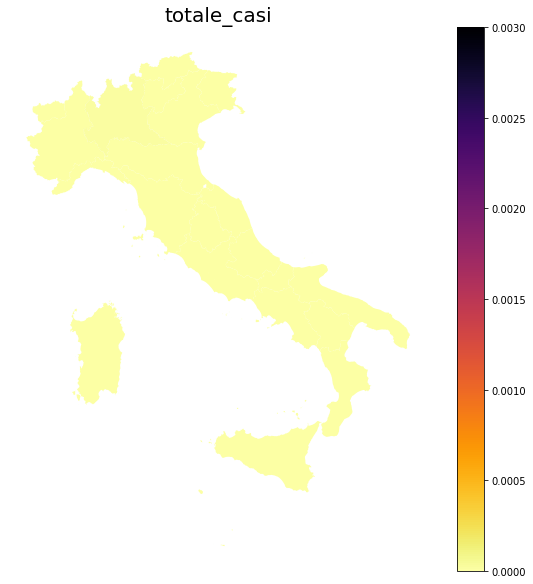

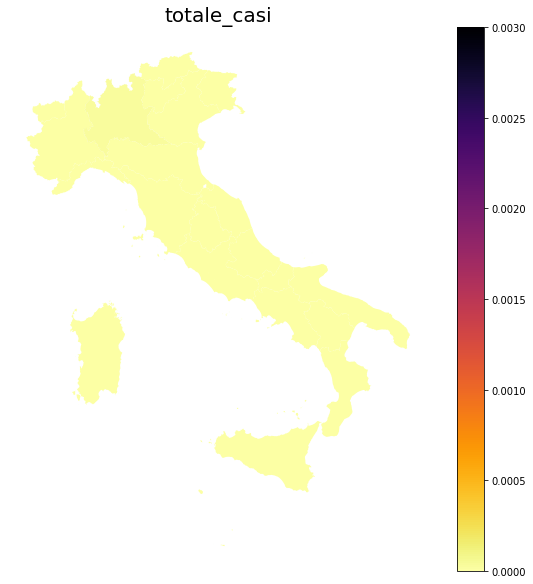

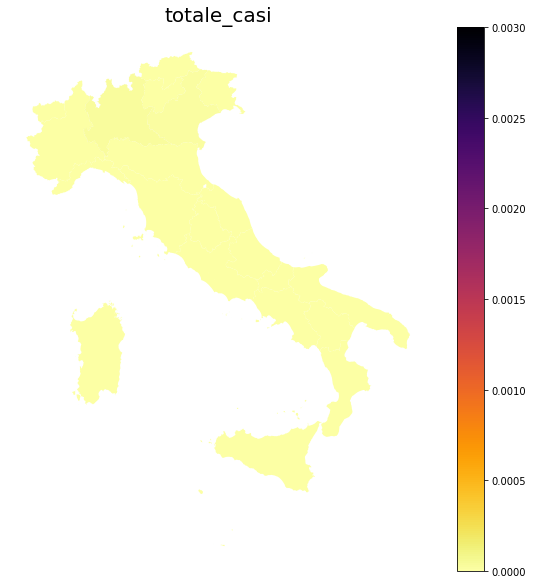

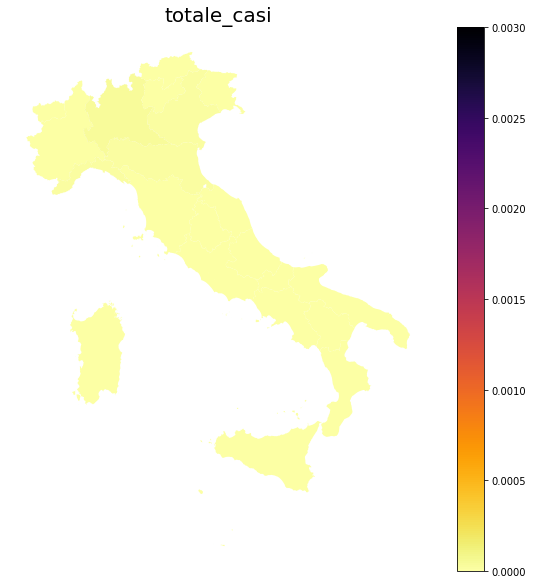

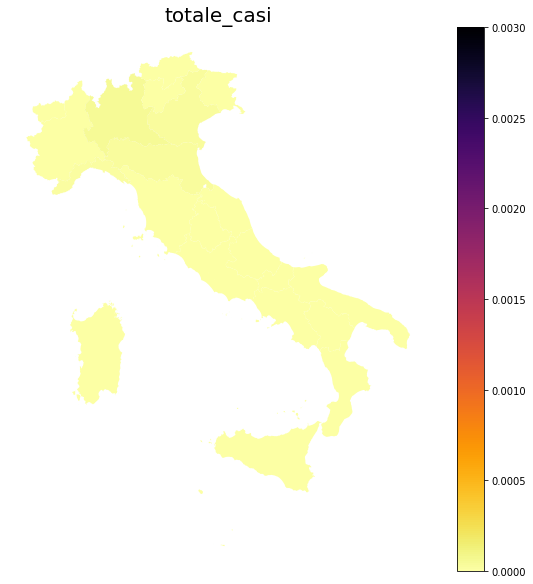

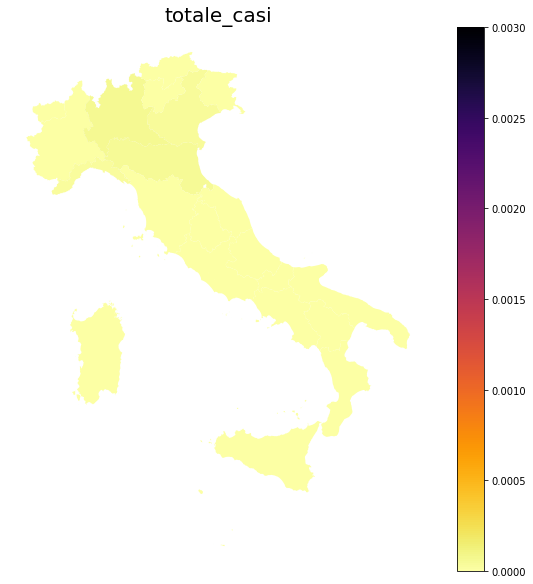

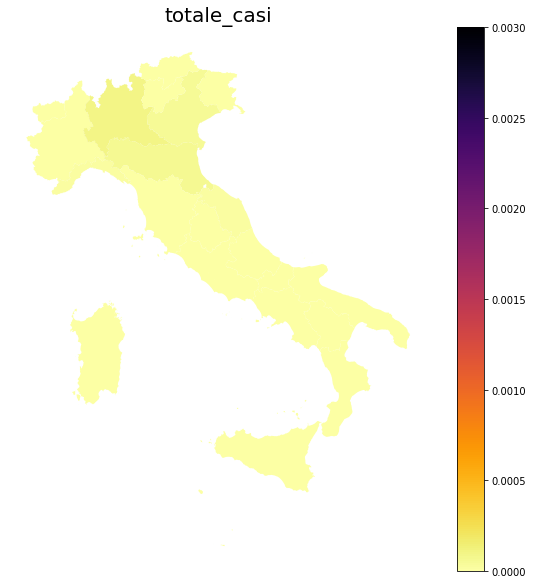

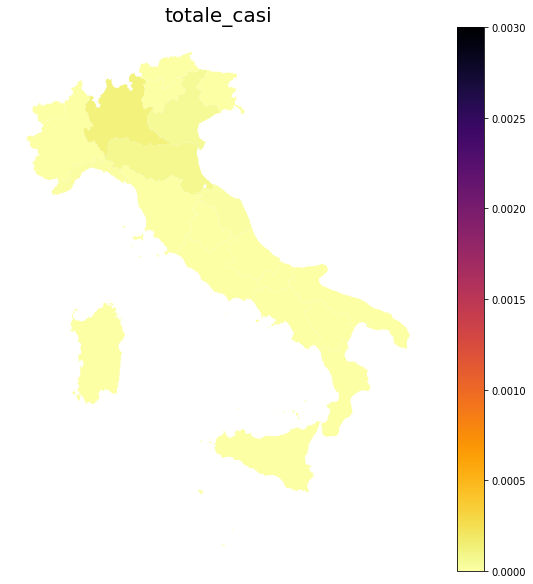

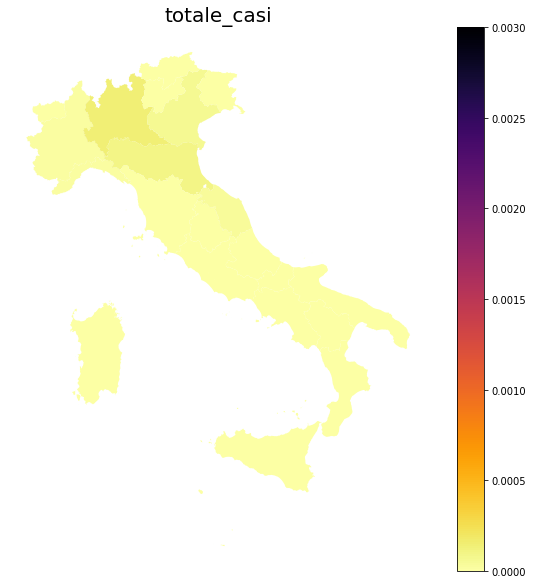

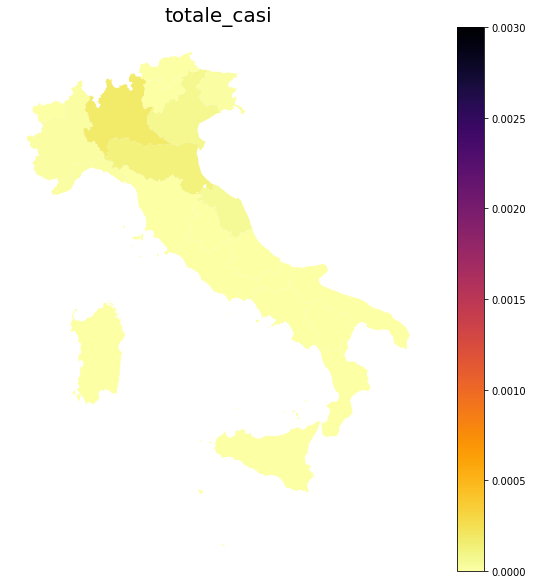

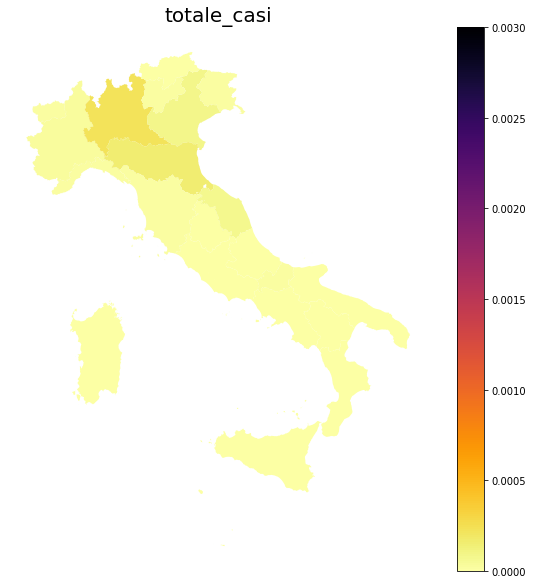

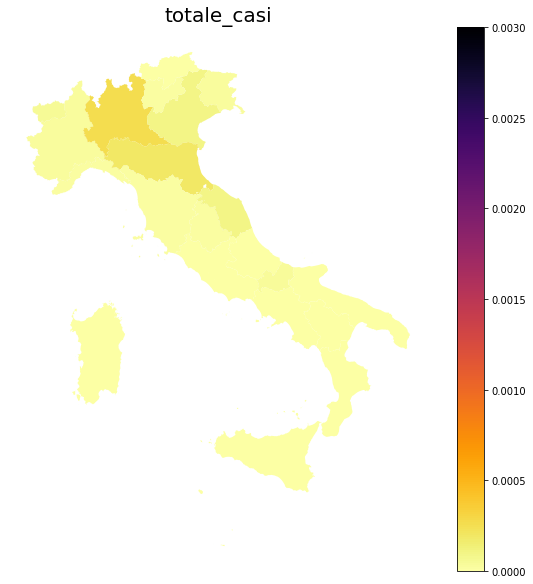

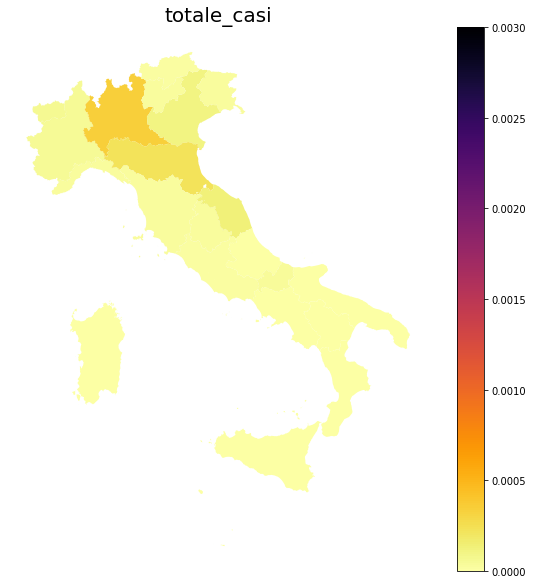

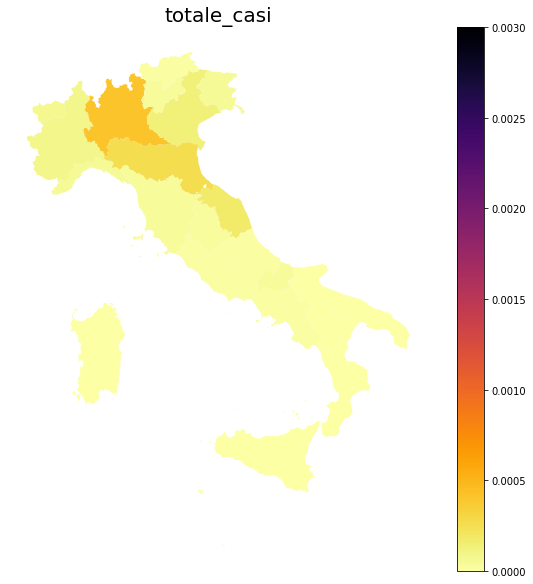

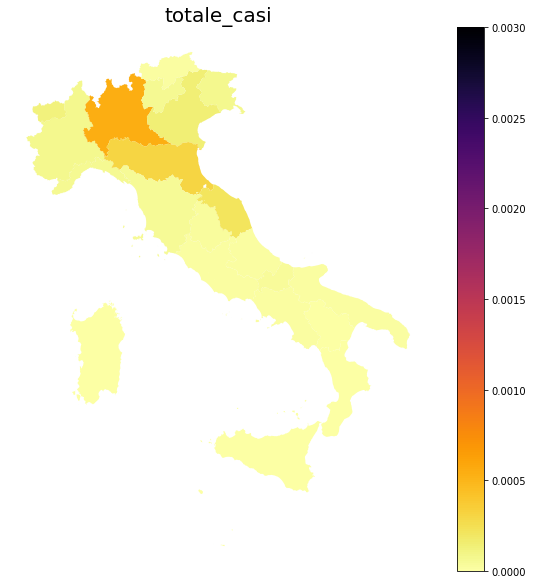

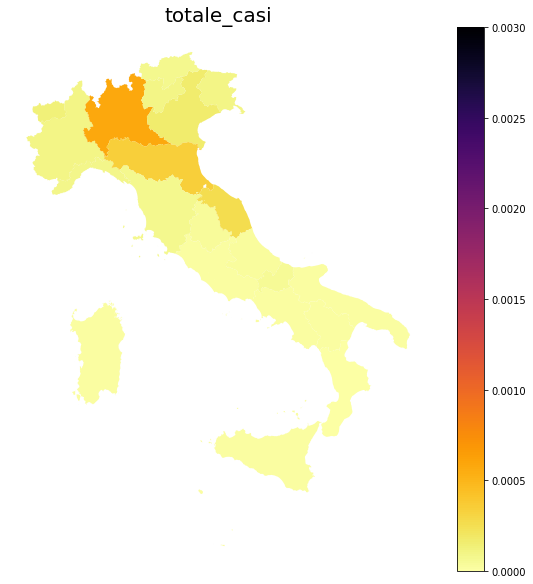

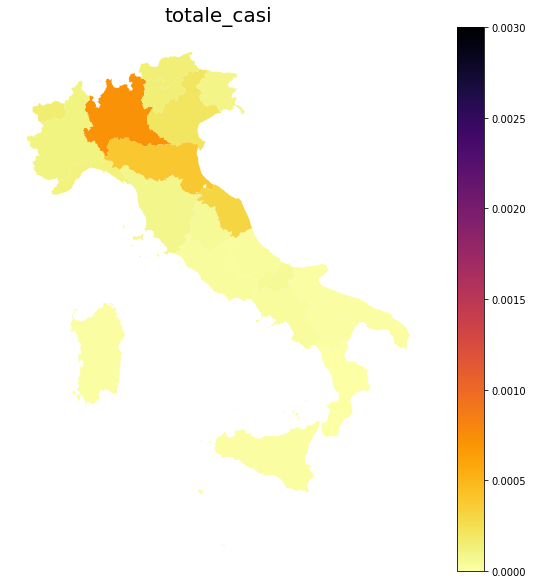

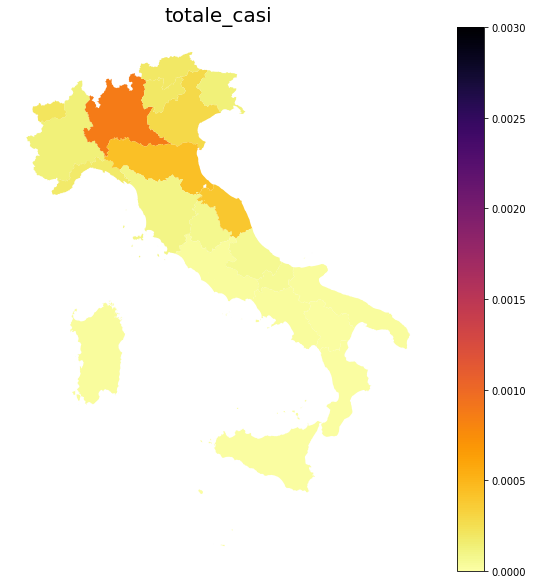

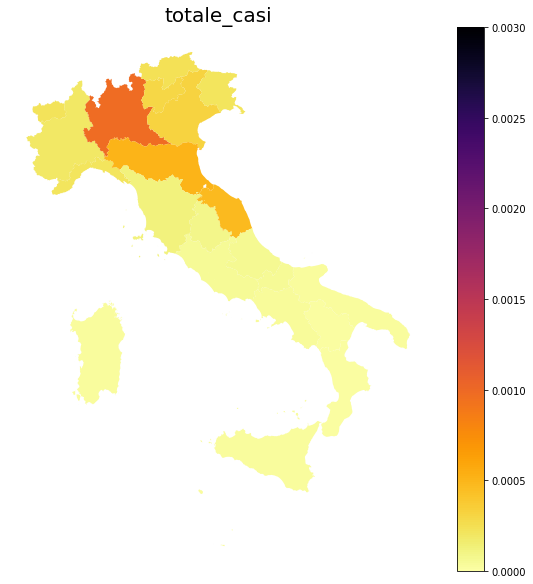

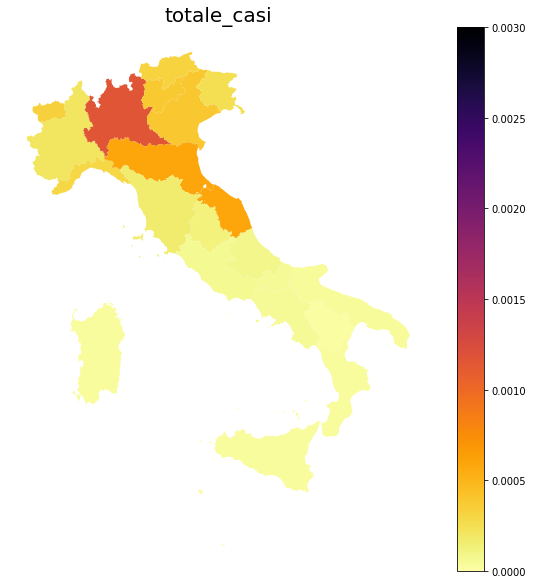

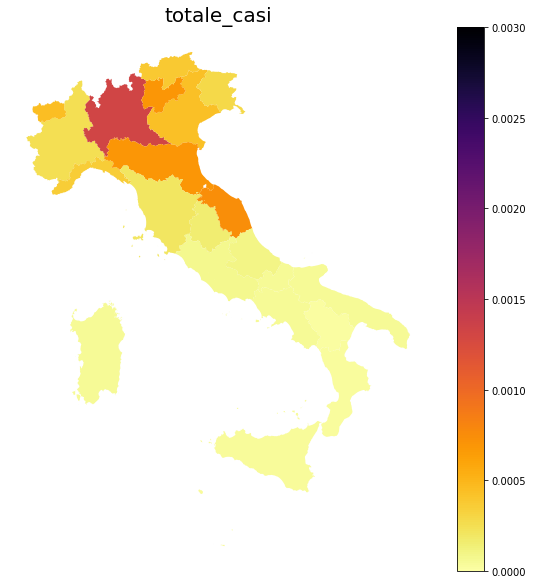

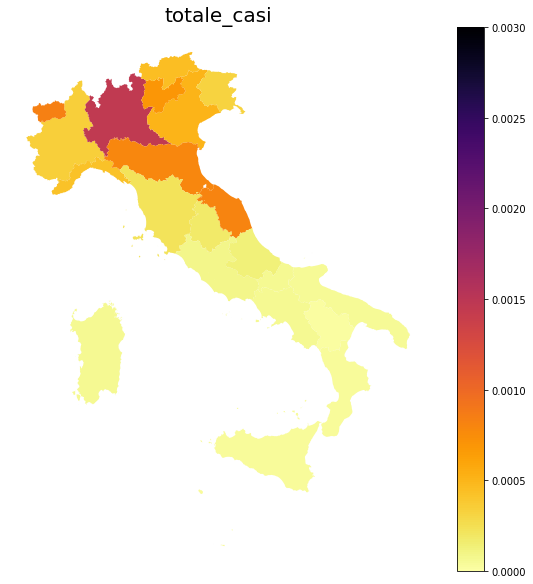

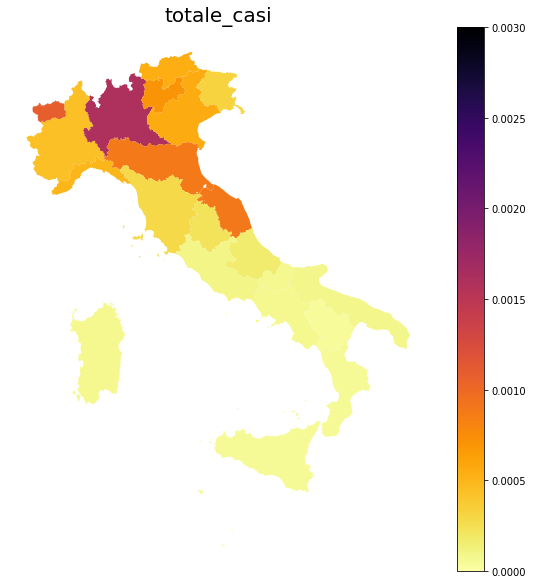

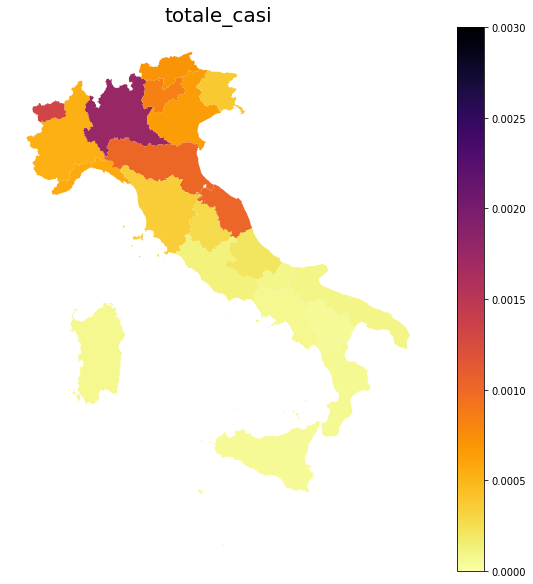

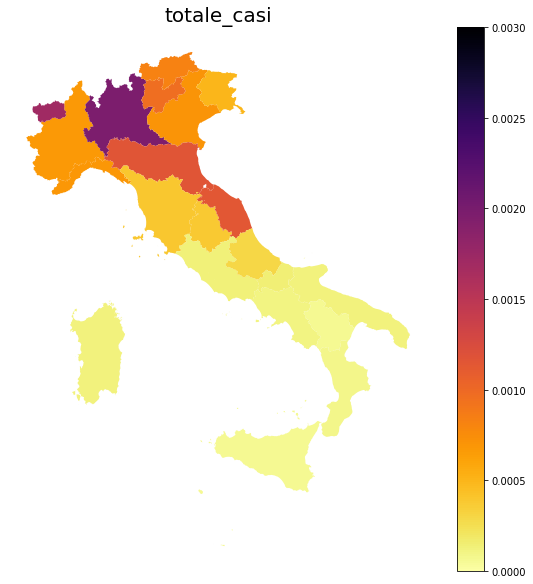

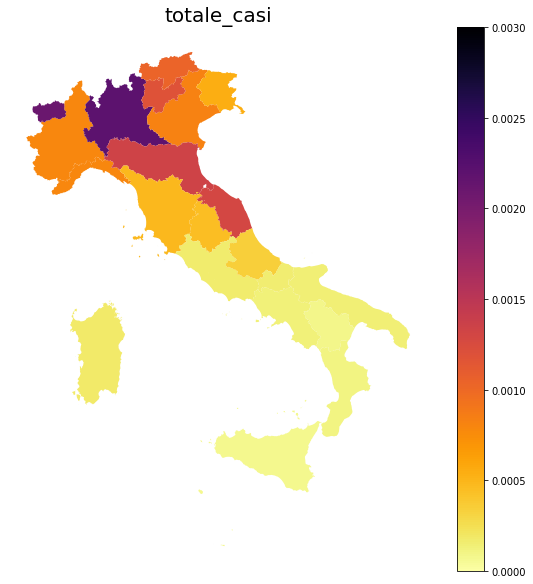

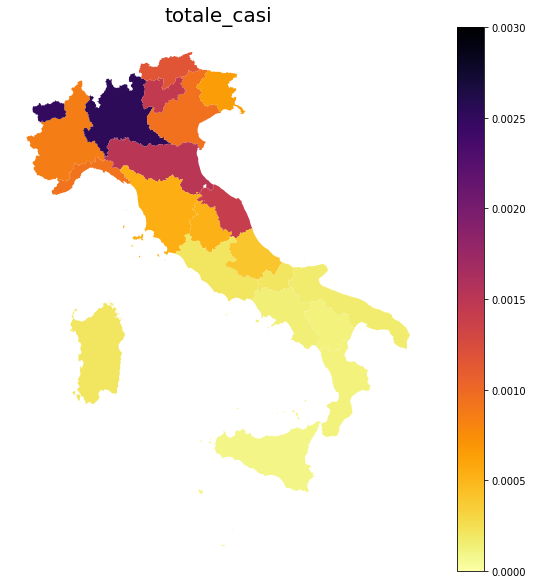

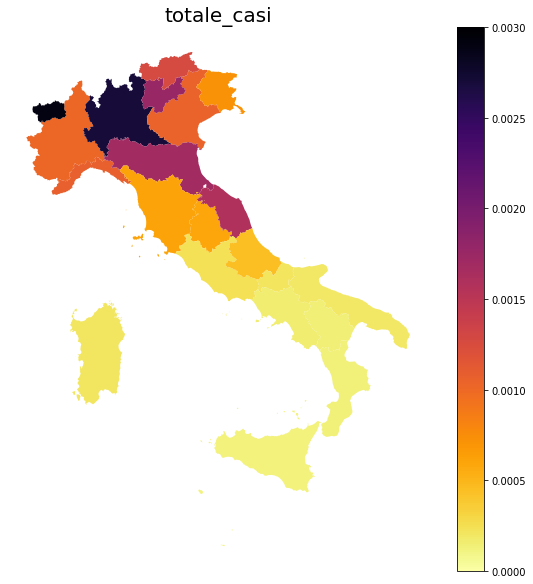

In [54]:
variable = 'totale_casi'
vmin, vmax  = min(dfr[variable].values), max(dfr[variable].values)
vmin, vmax = vmin, 0.003
ims = []

for d in pd.date_range(min(dfr.data), max(dfr.data)):
    fig, ax = plt.subplots(1,figsize=(10,10))
    dftemp = dfr[dfr.data.dt.date == d.date()].copy()
    mergedrr = mapr_df.set_index('DEN_REG').copy().join(dftemp.set_index('denominazione_regione'))
    mergedrr = mergedrr.join(dfpop.set_index('denominazione_regione')['popolazione'])
    mergedrr['perc_'+variable] = mergedrr[[variable, 'popolazione']].apply(lambda x: x[0]/x[1], axis = 1)
    print (mergedrr['perc_'+variable])
    mergedrr['log_'+variable] = mergedrr[variable].apply(lambda x: max(0,np.log10(x)))
    mergedrr['log_perc_'+variable] = mergedrr[[variable, 'popolazione']].apply(lambda x: np.log10(x[0]/x[1]), axis = 1)
    
    col = 'perc_'+variable
    ims.append([mergedrr.plot(column = col, cmap = 'inferno_r', ax = ax, legend = True, norm=plt.Normalize(vmin=vmin, vmax=vmax))]);
    ax.axis('off')
    ax.set_title(variable, fontdict={'fontsize':'20'})
    ax.set_xlabel('Day: {}'.format(d.date))
    plt.savefig('plot/geomap_'+col+'_'+str(d.date())+'.png')

In [ ]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr[dfr.].set_index('denominazione_regione'))
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr = mergedr.rename(index = {'Trento': 'P.A. Trento', 'Bolzano': 'P.A. Bolzano'})
mergedr = mergedr.join(df.set_index('denominazione_regione')['popolazione'])

#mergedr.loc['P. A. Trento',:] = mergedr['Trento']
#mergedr.loc['P. A. Bolzano',:] = mergedr['Bolzano']